In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pyranges as pr
import itertools
import functions as fn
from collections import defaultdict
import os
from pyfaidx import Fasta
from Bio.Seq import Seq



In [2]:
chr1_test = False
qval_threshold = 0 # 1.3 corresponds to pvalue of 0.05, 1 corresponds to pvalue of 0.1
macs_folddiff_threshold = 0
min_interval_size = 200
frac_overlap = 0.5 # fraction of peak overlap to be considered overlapping

In [5]:
dup_file = "/Genomics/kocherlab/bjarnold/STARRseq/data/peak_calling_snakemake_output/multiqc_data/multiqc_markdup.txt"
dup_df = pd.read_csv(dup_file, sep="\t")
dup_df = dup_df[['Sample', 'duplicate_rate']]
# reformat smaple names for Lalb and Sinv, which also have sub populations
dup_df['Sample'] = dup_df['Sample'].str.replace('Lalb-', 'Lalb_')
dup_df['Sample'] = dup_df['Sample'].str.replace('Sinv-', 'Sinv_')

dup_df['duplicate_rate'] = dup_df['duplicate_rate']/100
# in dup_df data frame, take the Sample column and split it into three columns separated by '-'
dup_df[['Species', 'BioRep', 'Condition']] = dup_df['Sample'].str.split('-', expand=True)
# for "condition" column, remove _dedup from each element
dup_df['Condition'] = dup_df['Condition'].str.replace('_dedup', '')
dup_df.head()

,Sample,duplicate_rate,Species,BioRep,Condition
0,Aaur-F1-RNA_dedup,0.826308,Aaur,F1,RNA
1,Aaur-F1-input_dedup,0.475705,Aaur,F1,input
2,Aaur-F2-RNA_dedup,0.690783,Aaur,F2,RNA
3,Aaur-F2-input_dedup,0.524761,Aaur,F2,input
4,Aaur-F3-RNA_dedup,0.657578,Aaur,F3,RNA


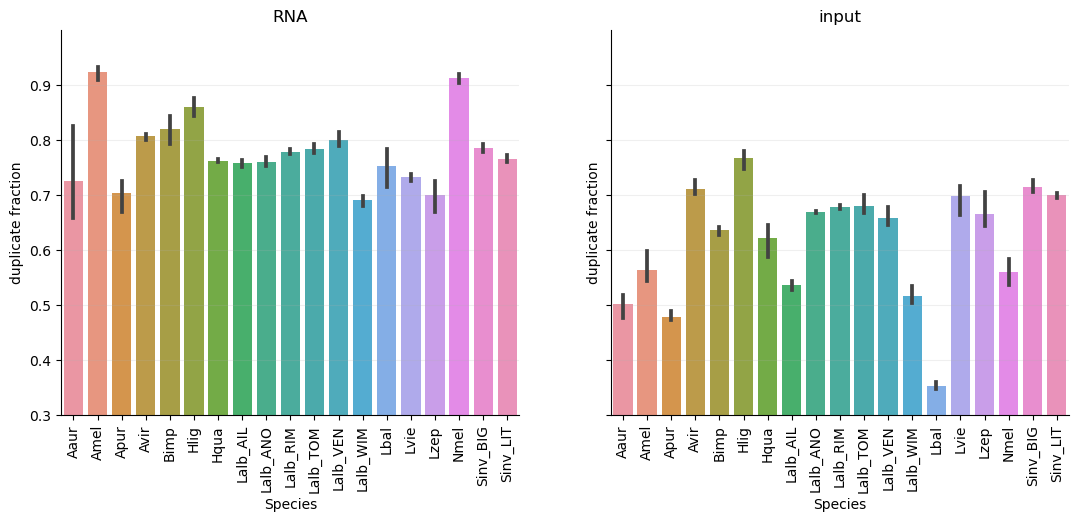

In [22]:
# make a seaborn barplot, of the duplicate_rate by species
fig, axs = plt.subplots(1,2, figsize=(13,5), sharey=True)
sns.barplot(x='Species', y='duplicate_rate', data=dup_df[dup_df['Condition'] == 'RNA'], ax=axs[0])
sns.barplot(x='Species', y='duplicate_rate', data=dup_df[dup_df['Condition'] == 'input'], ax=axs[1])
# add gridlines
axs[0].grid(axis='y', alpha=0.2)
axs[1].grid(axis='y', alpha=0.2)
# specify y axis ticks
axs[0].set_yticks(np.arange(0, 1, 0.1))
axs[1].set_yticks(np.arange(0, 1, 0.1))
axs[0].set_title('RNA')
axs[1].set_title('input')
axs[0].set_ylabel('duplicate fraction')
axs[1].set_ylabel('duplicate fraction')

axs[0].set_ylim(0.3, 1)
axs[1].set_ylim(0.3, 1)
# rotate x axis labels by 45 degrees
for ax in axs:
    ax.tick_params(axis='x', labelrotation=90)
sns.despine()

I've analyzed a lot of WGS data, and the input libraries seem to have low complexity, 8 out of 10 species are mostly PCR duplicates
From Kim et al (2021) Genome Research:

    - We checked duplicated rate for each cycle using Picard (MarkDuplicates, version 2.14.0). The mean duplicate rate for each cycle is as follows: 0.3% in Cycle 3; 0.5% in Cycle 6; 1.3% in Cycle 12; 1.9% in Cycle 18

In [11]:
species = list(dup_df['Species'].unique())
print(species)
results = defaultdict(list)

for s in species:
    if 'Lalb' in s or 'Sinv' in s:
        s = s.split('_')[0]
    d = f"/Genomics/kocherlab/bjarnold/STARRseq/data/peak_calling_snakemake_output/{s}"
    # load MACS peak files
    macs_raw_files = fn.get_files(f'{d}/MACS2', "*_peaks.narrowPeak")
    macs_dedup_files = fn.get_files(f'{d}/MACS2_dedup', "*_peaks.narrowPeak")

    macs_raw_dfs = fn.load_peak_caller_results(macs_raw_files, chr1_test) # list of macs dataframes
    macs_dedup_dfs = fn.load_peak_caller_results(macs_dedup_files, chr1_test) # list of macs dataframes

    macs_raw_dfs = fn.filter_by_sig_effect_size(macs_raw_dfs, qval_threshold, macs_folddiff_threshold)
    macs_dedup_dfs = fn.filter_by_sig_effect_size(macs_dedup_dfs, qval_threshold, macs_folddiff_threshold)

    macs_raw_prs = [pr.PyRanges(m) for m in macs_raw_dfs]
    macs_dedup_prs = [pr.PyRanges(m) for m in macs_dedup_dfs]


    for i,(dedup,raw) in enumerate(zip(macs_dedup_prs, macs_raw_prs)):
        tmp = dedup.join(raw, suffix="_raw", how="left")
        c = np.corrcoef(tmp.df['signalValue'], tmp.df['signalValue_raw'])[0,1]
        results[s].append(c)

results

['Aaur', 'Amel', 'Apur', 'Avir', 'Bimp', 'Hlig', 'Hqua', 'Lalb_AIL', 'Lalb_ANO', 'Lalb_RIM', 'Lalb_TOM', 'Lalb_VEN', 'Lalb_WIM', 'Lbal', 'Lvie', 'Lzep', 'Nmel', 'Sinv_BIG', 'Sinv_LIT']
before filtering: 47505
after filtering: 47505
before filtering: 38363
after filtering: 38363
before filtering: 35177
after filtering: 35177
before filtering: 3941
after filtering: 3941
before filtering: 3500
after filtering: 3500
before filtering: 3224
after filtering: 3224
before filtering: 41677
after filtering: 41677
before filtering: 40660
after filtering: 40660
before filtering: 41242
after filtering: 41242
before filtering: 21798
after filtering: 21798
before filtering: 23397
after filtering: 23397
before filtering: 32193
after filtering: 32193
before filtering: 60285
after filtering: 60285
before filtering: 57610
after filtering: 57610
before filtering: 53509
after filtering: 53509
before filtering: 10142
after filtering: 10142
before filtering: 10283
after filtering: 10283
before filtering: 9574

defaultdict(list,
            {'Aaur': [0.11827624066543599,
              0.2113762658448607,
              0.24180454737263832],
             'Amel': [0.44366425494368616,
              0.4025349788674147,
              0.46555853687668236],
             'Apur': [0.38362719597406675,
              0.38407124143856375,
              0.43598001898908983],
             'Avir': [0.27947356004481416,
              0.2871987985425736,
              0.249851620118996],
             'Bimp': [0.14873842839190815,
              0.15955461859381542,
              0.29961602474790844],
             'Hlig': [0.27975353321309465,
              0.18047430731030953,
              0.18411516952775117],
             'Hqua': [0.48434624619871536,
              0.4842136075169557,
              0.48057242897785085],
             'Lalb': [0.510858541386033,
              0.5143358885071139,
              0.519055205727643,
              0.7432699140202501,
              0.7549895655702857,
              

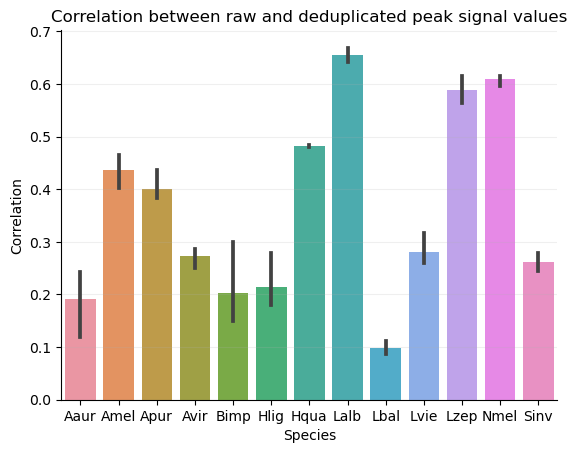

In [15]:
results_df = pd.concat(pd.DataFrame({'Species':k, 'Correlation':v}) for k, v in results.items())
# results_df = pd.DataFrame(results)
# convert results_df from wide format to long format using melt
# results_df = results_df.melt()
# results_df.columns = ['Species', 'Correlation']
results_df.head()
sns.barplot(x='Species', y='Correlation', data=results_df)
plt.title('Correlation between raw and deduplicated peak signal values')
plt.grid(axis='y', alpha=0.2)
sns.despine()



In [27]:
species = "Lbal"
bioreps = ['F1', 'F2', 'F3']



In [20]:
base_dir = "/Genomics/kocherlab/bjarnold/STARRseq/data/peak_calling_snakemake_output"

wd = f"{base_dir}/{species}"

# load MACS peak files
macs_raw_files = fn.get_files(f'{wd}/MACS2', "*_peaks.narrowPeak")
macs_dedup_files = fn.get_files(f'{wd}/MACS2_dedup', "*_peaks.narrowPeak")

# 1. chromosome
# 2. start
# 3. end
# 4. name
# 5. score
# 6. strand
# 7. signalValue - measurement of overall enrichment for the region
# 8. pValue - statistical significance (-log10)
# 9. qValue - statistical significance using false discovery rate (-log10)
# 10. peak - Point-source called for this peak; -based offset from chromStart

print(macs_raw_files)
print(macs_dedup_files)

['/Genomics/kocherlab/bjarnold/STARRseq/data/peak_calling_snakemake_output/Lbal/MACS2/Lbal-F1_peaks.narrowPeak', '/Genomics/kocherlab/bjarnold/STARRseq/data/peak_calling_snakemake_output/Lbal/MACS2/Lbal-F2_peaks.narrowPeak', '/Genomics/kocherlab/bjarnold/STARRseq/data/peak_calling_snakemake_output/Lbal/MACS2/Lbal-F3_peaks.narrowPeak']
['/Genomics/kocherlab/bjarnold/STARRseq/data/peak_calling_snakemake_output/Lbal/MACS2_dedup/Lbal-F1_peaks.narrowPeak', '/Genomics/kocherlab/bjarnold/STARRseq/data/peak_calling_snakemake_output/Lbal/MACS2_dedup/Lbal-F2_peaks.narrowPeak', '/Genomics/kocherlab/bjarnold/STARRseq/data/peak_calling_snakemake_output/Lbal/MACS2_dedup/Lbal-F3_peaks.narrowPeak']


In [21]:
macs_raw_dfs = fn.load_peak_caller_results(macs_raw_files, chr1_test) # list of macs dataframes
macs_dedup_dfs = fn.load_peak_caller_results(macs_dedup_files, chr1_test) # list of macs dataframes

macs_raw_dfs = fn.filter_by_sig_effect_size(macs_raw_dfs, qval_threshold, macs_folddiff_threshold)
macs_dedup_dfs = fn.filter_by_sig_effect_size(macs_dedup_dfs, qval_threshold, macs_folddiff_threshold)


before filtering: 101058
after filtering: 101058
before filtering: 98260
after filtering: 98260
before filtering: 85703
after filtering: 85703
before filtering: 11859
after filtering: 11859
before filtering: 12556
after filtering: 12556
before filtering: 13918
after filtering: 13918


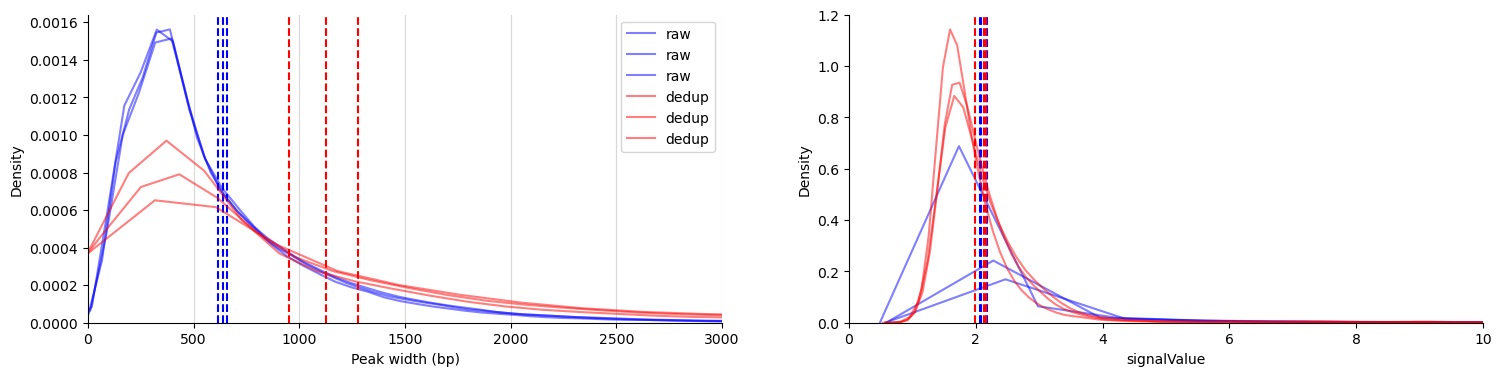

In [22]:
# note for Genrich, peaks thresholded by q value selects for wider peaks with larger q values
fig, axs = plt.subplots(1, 2, figsize=(18, 4))

for df in macs_raw_dfs:
    sns.kdeplot(df['End']-df['Start'], color="blue", alpha=0.5, label="raw", ax=axs[0])
    axs[0].axvline(x=np.mean(df['End']-df['Start']), color="blue", linestyle='--')
for df in macs_dedup_dfs:
    sns.kdeplot(df['End']-df['Start'], color="red", alpha=0.5, label="dedup", ax=axs[0])
    axs[0].axvline(x=np.mean(df['End']-df['Start']), color="red", linestyle='--')
axs[0].set_xlim(0,3000)
axs[0].set_xlabel("Peak width (bp)")
axs[0].set_ylabel("Density")
axs[0].grid(axis='x', alpha=0.5)  
# add legend
handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles, labels)

for df in macs_raw_dfs:
    sns.kdeplot(df['signalValue'], color="blue", alpha=0.5, label="raw", ax=axs[1], bw_adjust=0.5)
    axs[1].axvline(x=np.mean(df['signalValue']), color="blue", linestyle='--')
for df in macs_dedup_dfs:
    sns.kdeplot(df['signalValue'], color="red", alpha=0.5, label="dedup", ax=axs[1], bw_adjust=1)
    axs[1].axvline(x=np.mean(df['signalValue']), color="red", linestyle='--')
axs[1].set_xlim(0,10)

sns.despine()


In [23]:
macs_raw_prs = [pr.PyRanges(m) for m in macs_raw_dfs]
macs_dedup_prs = [pr.PyRanges(m) for m in macs_dedup_dfs]

original df length: 11859
df length after join: 13316
[[1.        0.0860397]
 [0.0860397 1.       ]]
original df length: 12556
df length after join: 13822
[[1.        0.1002311]
 [0.1002311 1.       ]]
original df length: 13918
df length after join: 14906
[[1.         0.11083318]
 [0.11083318 1.        ]]


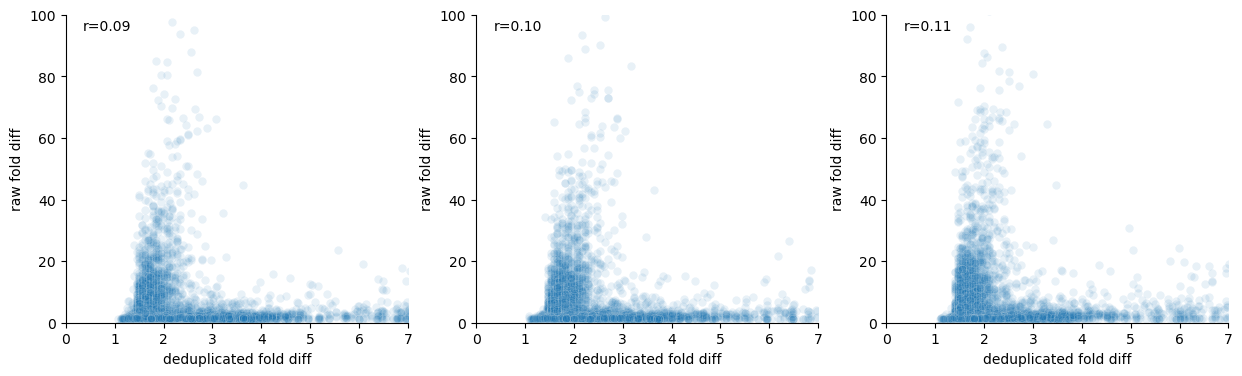

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

for i,(dedup,raw) in enumerate(zip(macs_dedup_prs, macs_raw_prs)):
    tmp = dedup.join(raw, suffix="_raw", how="left")
    print("original df length:", len(dedup))
    print("df length after join:", len(tmp))
    sns.scatterplot(data=tmp.df, x="signalValue", y="signalValue_raw", alpha=0.1, ax=axs[i])   
    axs[i].set_xlim(0,7)
    axs[i].set_ylim(0,100)

    axs[i].set_xlabel("deduplicated fold diff")
    axs[i].set_ylabel("raw fold diff")

    # add correlation coefficient to plot
    axs[i].text(0.05, 0.95, f"r={np.corrcoef(tmp.df['signalValue'], tmp.df['signalValue_raw'])[0,1]:.2f}", transform=axs[i].transAxes)
    print(np.corrcoef(tmp.df["signalValue"], tmp.df["signalValue_raw"]))

sns.despine()


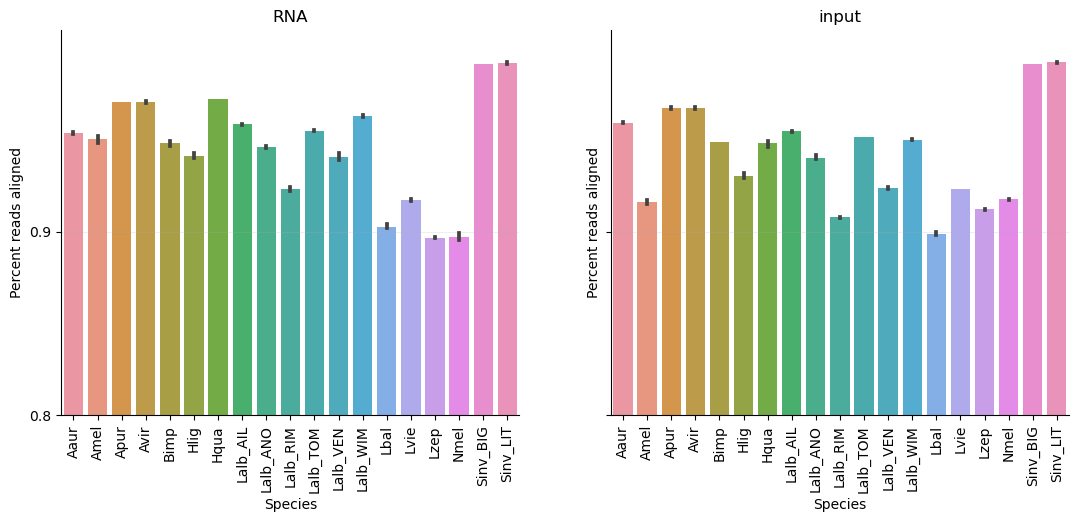

In [24]:
alig_file = "/Genomics/kocherlab/bjarnold/STARRseq/data/peak_calling_snakemake_output/multiqc_data/multiqc_picard_AlignmentSummaryMetrics.txt"

alig_df = pd.read_csv(alig_file, sep="\t")
alig_df = alig_df[['Sample', 'PCT_PF_READS_ALIGNED']]
# remove rows of align_df that contain 'Sinv'
alig_df['Sample'] = alig_df['Sample'].str.replace('Lalb-', 'Lalb_')
alig_df['Sample'] = alig_df['Sample'].str.replace('Sinv-', 'Sinv_')

# alig_df = alig_df[~alig_df['Sample'].str.contains('Sinv')]
alig_df[['Species', 'BioRep', 'Condition']] = alig_df['Sample'].str.split('-', expand=True)
alig_df['Condition'] = alig_df['Condition'].str.replace('_csorted', '')
alig_df.head()

# make a seaborn barplot, of the duplicate_rate by species
fig, axs = plt.subplots(1,2, figsize=(13,5), sharey=True)
sns.barplot(x='Species', y='PCT_PF_READS_ALIGNED', data=alig_df[alig_df['Condition'] == 'RNA'], ax=axs[0])
sns.barplot(x='Species', y='PCT_PF_READS_ALIGNED', data=alig_df[alig_df['Condition'] == 'input'], ax=axs[1])
axs[0].set_title('RNA')
axs[1].set_title('input')
axs[0].set_yticks(np.arange(0, 1, 0.1))
axs[1].set_yticks(np.arange(0, 1, 0.1))
axs[0].grid(axis='y', alpha=0.2)
axs[1].grid(axis='y', alpha=0.2)
axs[0].set_ylabel('Percent reads aligned')
axs[1].set_ylabel('Percent reads aligned')

axs[0].set_ylim(0.8, 1.01)
axs[1].set_ylim(0.8, 1.01)

# rotate x axis labels by 45 degrees
for ax in axs:
    ax.tick_params(axis='x', labelrotation=90)
    
sns.despine()


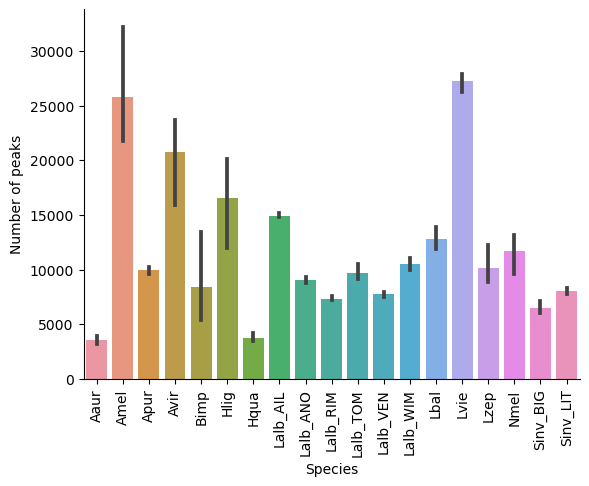

In [21]:
macs_file = "/Genomics/kocherlab/bjarnold/STARRseq/data/peak_calling_snakemake_output/multiqc_data/multiqc_macs.txt"

macs_df = pd.read_csv(macs_file, sep="\t")
macs_df = macs_df[['Sample', 'peak_count']]
# remove rows of align_df that contain 'Sinv'
macs_df['Sample'] = macs_df['Sample'].str.replace('Lalb-', 'Lalb_')
macs_df['Sample'] = macs_df['Sample'].str.replace('Sinv-', 'Sinv_')
macs_df[['Species', 'BioRep']] = macs_df['Sample'].str.split('-', expand=True)
# make a seaborn barplot, of the duplicate_rate by species
sns.barplot(x='Species', y='peak_count', data=macs_df)
plt.ylabel('Number of peaks')
# rotate x axis labels by 45 degrees
plt.tick_params(axis='x', labelrotation=90)
sns.despine()